# PS Parallel Programming / Sheet 04
# Fabio Valentini / MN 01018782

In [1]:
# initial setup

import subprocess

from IPython.display import HTML, set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parse

%matplotlib inline
set_matplotlib_formats('svg')

SAMPLE_SIZE = 10
THREADS = 16

## Exercise 3: Parallel Merge-Sort

- sequential program: `./msort/msort_seq.c`
- parallel OpenMP program: `./msort/msort_seq.c`

### Implementation details

#### General implementation

Most of the algorithm is shared between the sequential and parallelized recursive programs:

- allocate *one* big second array of equal size as temporary memory for the `merge` algorithm
  - in-place merge-sort is apparently slow, and complicated to implement correctly
  - one big allocation is (empirically) faster than two smaller allocations for *each* recursive call
- implement a small optimization for arrays of size two
  - just swap elements if necessary, without two more recursive calls
  - reduces number of recursive calls by about 33%
- algorithm verified with basic tests
  - empty array
  - array of length 1
  - arrays of length 10 (with and without duplicate elements)
- basic smoke test checks if output array is indeed sorted (not part of wall time measurement)
- verified absence of memory leaks or invalid memory accesses with valgrind

#### Parallel implementation

- allow nested parallelism (otherwise only the two toplevel tasks are executed in parallel): `omp_set_nested(1)`
- limit depth of nested tasks that are executed in parallel (they don't seem to count against `OMP_NUM_THREADS`): `omp_set_max_active_levels(limit)`, depending on the value of `OMP_NUM_THREADS`
- create two OpenMP Tasks for sorting the left and right sub-arrays: `#pragma omp task`
- wait for both subtasks to finish before merging the results: `#pragma omp taskwait`
- only the recursive calls to `msort_rec` are parallelized
- the `merge` algorithm is not parallelized

### Local Performance Measurements

In [2]:
parser = parse.Parser("time: {time:.5f} seconds")

sequentials = []

# run sequential merge-sort implementation
for i in range(SAMPLE_SIZE):
    ret = subprocess.run(
        ["./msort/msort_seq"],
        stdout=subprocess.PIPE,
    )
    sequentials.append(parser.parse(ret.stdout.decode())["time"])

sequential_fastest = np.array(sequentials).min()

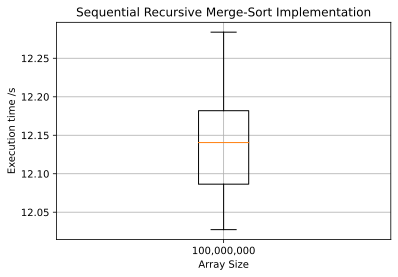

In [3]:
plt.boxplot([sequentials], labels=["100,000,000"])

plt.title("Sequential Recursive Merge-Sort Implementation")
plt.xlabel("Array Size")
plt.ylabel("Execution time /s")

plt.grid()
plt.show()

The sequential recursive algorithm had very predictable performance, with few outliers.

In [4]:
parallels = []

threads = [*range(1, THREADS+1)]

# run parallelized merge-sort implementation
for p in threads:
    ret = subprocess.run(
        ["./msort/msort_par"],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    parallels.append(parser.parse(ret.stdout.decode())["time"])

speedups = sequential_fastest / parallels

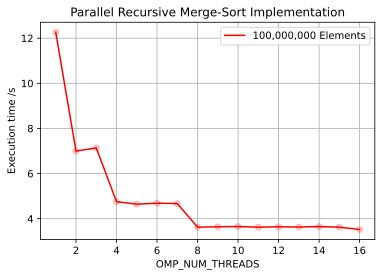

In [5]:
plt.plot(threads, parallels, "ro", alpha=0.2)
plt.plot(threads, parallels, "r-", label="100,000,000 Elements")

plt.title("Parallel Recursive Merge-Sort Implementation")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

The effectiveness of parallelizing merge-sort was limited by the maximum depth of nested parallelism, so only after each power of two there was a noticable improvement in performance.

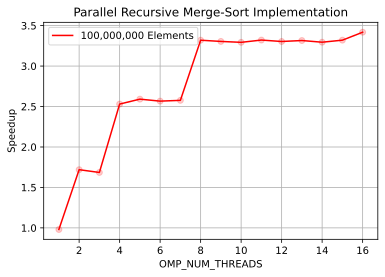

In [6]:
plt.plot(threads, speedups, "ro", alpha=0.2)
plt.plot(threads, speedups, "r-", label="100,000,000 Elements")

plt.title("Parallel Recursive Merge-Sort Implementation")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

The best achievable speedup with this parallel implementation seems to be short of a factor of 4 for 16 threads. Looking at profiling data, about 5-10% of execution time at each recursive step is spent in the sequential `merge` algorithm, which could explain the limited achievable speedup with this implementation.

In [7]:
data = np.array([threads, parallels, speedups]).T

df = pd.DataFrame(
    data,
    index=threads,
    columns=[
        "OMP_NUM_THREADS",
        "Execution time / s",
        "Speedup",
    ]
)

HTML(df.to_html(index=False))

OMP_NUM_THREADS,Execution time / s,Speedup
1.0,12.26781,0.980406
2.0,6.99544,1.719324
3.0,7.13696,1.685232
4.0,4.75329,2.530338
5.0,4.64177,2.591130
6.0,4.68601,2.566668
7.0,4.66860,2.576239
8.0,3.62315,3.319606
9.0,3.63970,3.304511
10.0,3.65210,3.293292


### LCC2 Performance Measurements

- job script: `./msort/sheet_04_3.job.sh`
- job output: `./msort/sheet_04_3.dat`

In [8]:
lcc2_sequentials = [
    39.94144,
    39.96415,
    40.01096,
    39.94729,
]

lcc2_sequential_fastest = np.array(lcc2_sequentials).min()

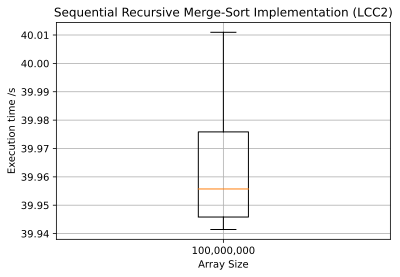

In [9]:
plt.boxplot([lcc2_sequentials], labels=["100,000,000"])

plt.title("Sequential Recursive Merge-Sort Implementation (LCC2)")
plt.xlabel("Array Size")
plt.ylabel("Execution time /s")

plt.grid()
plt.show()

In [10]:
lcc2_threads = [1, 2, 4, 8]

lcc2_parallels = [
    40.08679,
    25.48438,
    19.39156,
    16.82608,
]

lcc2_speedups = lcc2_sequential_fastest / lcc2_parallels

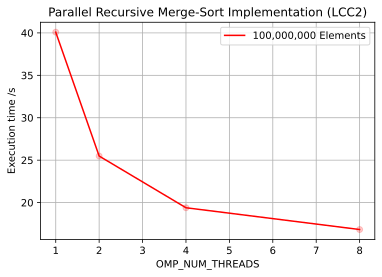

In [11]:
plt.plot(lcc2_threads, lcc2_parallels, "ro", alpha=0.2)
plt.plot(lcc2_threads, lcc2_parallels, "r-", label="100,000,000 Elements")

plt.title("Parallel Recursive Merge-Sort Implementation (LCC2)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

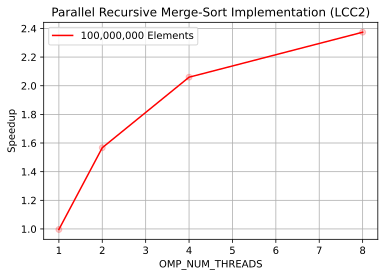

In [12]:
plt.plot(lcc2_threads, lcc2_speedups, "ro", alpha=0.2)
plt.plot(lcc2_threads, lcc2_speedups, "r-", label="100,000,000 Elements")

plt.title("Parallel Recursive Merge-Sort Implementation (LCC2)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

Since the number of threads was always an exact number of two, the jumps compared to the local performance measurements are not visible, otherwise, the results are comparable, with the speedup being limited to below a factor 4.

In [13]:
data = np.array([lcc2_threads, lcc2_parallels, lcc2_speedups]).T

df = pd.DataFrame(
    data,
    index=lcc2_threads,
    columns=[
        "OMP_NUM_THREADS",
        "Execution time / s",
        "Speedup",
    ]
)

HTML(df.to_html(index=False))

OMP_NUM_THREADS,Execution time / s,Speedup
1.0,40.08679,0.996374
2.0,25.48438,1.567291
4.0,19.39156,2.059733
8.0,16.82608,2.373782


## Hardware + Software

- CPU: AMD Ryzen 7 5800X (8 Cores, 16 Threads)
- OS: Fedora Workstation 34
- Compiler: `gcc (GCC) 11.0.1 20210405 (Red Hat 11.0.1-0)`
- Report: Python 3.9.4, Jupyter Notebook 6.1.6, IPython 7.20.0, ipykernel 5.4.3, numpy 1.20.1, matplotlib 3.4.1, pandas 1.2.1